In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

In [2]:
cheated_0 = Events('CheatedRecoFile_0.root')
sliced_0 = f.slice_events(cheated_0)
cheated_0_candidates = f.identify_candidate(cheated_0)
showers_0 = [r[1] for r in cheated_0_candidates if not cheated_0.is_true_track[r[1]]]
print(f'\nThere are {len(showers_0)} candidate showers in cheated_0')

Events sliced, 499617 events split across 9505 unique event ids

There are 4767 candidate showers in cheated_0


Debug for event 246701
    Lepton: Electron
    Angle info:
        Yaw = 1.19° from +w
        Upper Angle = 61.19°
        Lower Angle: -58.81°
    dE = 827079.375
    dx = 8.145986557006836
    dE/dx = 101532.13109449352



101532.13109449352

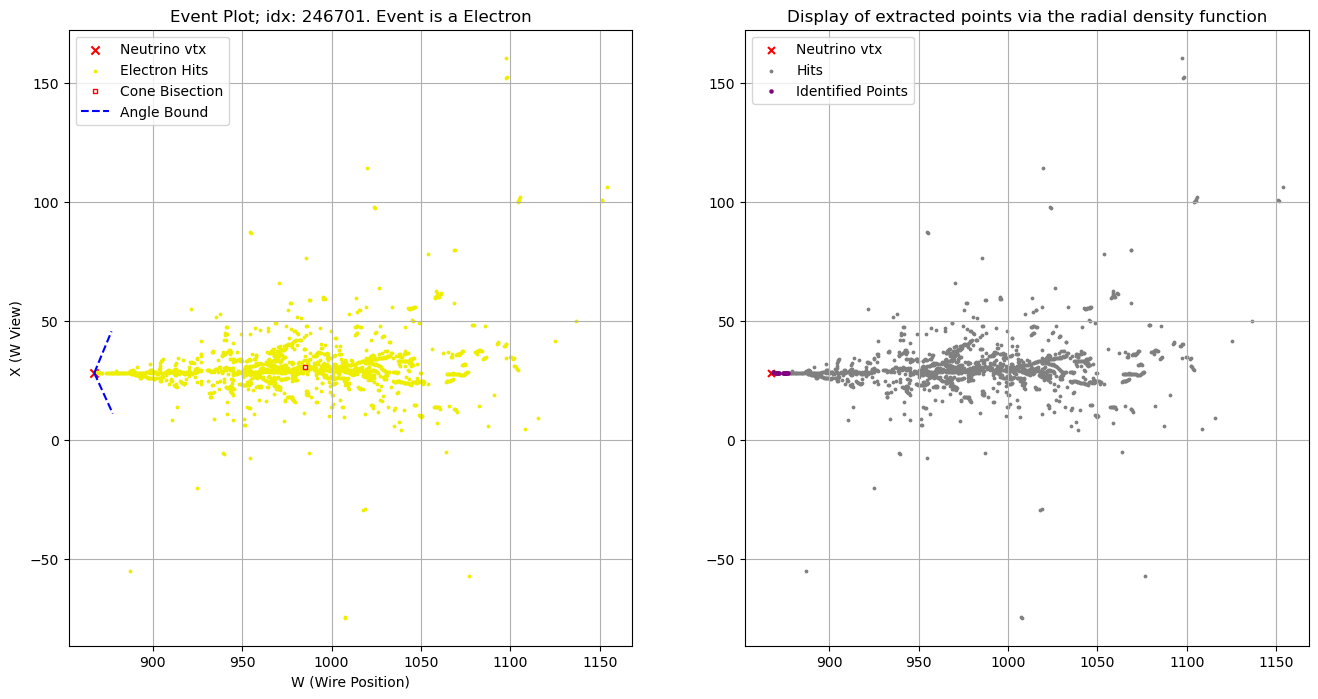

In [3]:
''' The feature code you need to copy '''
# I will mark things you can try and tweak for accuracy in the code with a comment with a brief description of how/why. I won't include ANY other comments.

def find_radial_density_increase(x, y, bins=50, center=None, start_radius=0, debug=False, safety_r=5):
    if center is None:
        center = (np.mean(x), np.mean(y))
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    r = r[r > start_radius]
    
    if len(r) == 0:
        return safety_r
    
    r_sorted = np.sort(r)
    
    bin_edges = np.linspace(start_radius, max(r_sorted), bins)
    counts, _ = np.histogram(r_sorted, bins=bin_edges)
    
    areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    densities = counts / areas
    
    diffs = np.diff(densities)
    increase_idx = np.argmax(diffs > 0)
    
    if increase_idx == 0 and diffs[0] <= 0:
        return safety_r
    
    return bin_edges[increase_idx]


def dEdx(events, event_idx, cone_angle=(2/3)*np.pi, debug=False, show_plot=False): # Put debug=True if you want all debug info, same with show_plot
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) <= 15:
        if debug:
            print(f'Event {event_idx} does not meet 15 hit cutoff\n')
        return None

    def debug_print(message):
        if debug:
            print(f"    {message}")
    if debug:
        print(f"Debug for event {event_idx}")
    
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    adcs = events.reco_adcs_w[event_idx]
    
    pdg = events.mc_pdg[event_idx]
    c_class = 'lightblue'
    event = 'ERROR: Not e/gamma'
    if pdg in [-11, 11]:
        c_class = '#EEEE00'
        event = 'Electron'
    elif pdg == 22:
        c_class = 'g'
        event = 'Photon'
    debug_print(f'Lepton: {event}')

    if np.sign(np.mean(w_hits) - w_vtx) == -1:
        w_hits = 2 * w_vtx - np.array(w_hits)
        debug_print(f'Event {event_idx} was left-facing, and has been inverted')

    theta_0 = np.arctan2(np.mean(x_hits) - x_vtx, np.mean(w_hits) - w_vtx)
    theta_u = theta_0 + (cone_angle/2)
    theta_l = theta_0 - (cone_angle/2)
    debug_print(f'Angle info:\n        Yaw = {np.degrees(theta_0):.2f}° from +w\n        Upper Angle = {np.degrees(theta_u):.2f}°\n        Lower Angle: {np.degrees(theta_l):.2f}°')
    
    # You may also want to play around with cone_angle, I don't expect it to have a super huge effect for values > pi/2

    angles = np.arctan2(x_hits - x_vtx, w_hits - w_vtx)
    distance = [np.sqrt((w - w_vtx)**2 + (x - x_vtx)**2) for w, x in zip(w_hits, x_hits)]

    r_start = 5
    if len(distance) >= 5:
        r_start = sorted(distance)[4]
        
    # r_start is arbitrary, just the distance from the event vertex that the radial density algorithm will begin searching, its good for events that start with a cluster and then a gap
    # worth tweaking if you really want to
    
    testing_distance = find_radial_density_increase(w_hits, x_hits, center = (w_vtx, x_vtx), start_radius = r_start)
    branch_distance = max(r_start + 5, testing_distance)
    
    mask = (angles >= theta_l) & (angles <= theta_u) & (distance < branch_distance)
    if mask.sum() == 0:
        print('ERROR: Mask is empty')
        return None

    points = np.column_stack((w_hits[mask], x_hits[mask]))
    di = np.sqrt(((points[:, None, :] - points[None, :, :]) ** 2).sum(axis=2))
    dx = np.maximum(np.max(di), 0.48)

    val = np.sum(adcs) / dx
    debug_print(f'dE = {np.sum(adcs)}')
    debug_print(f'dx = {dx}')
    debug_print(f'dE/dx = {val}\n')

    if show_plot:
        w_u = w_vtx + 20 * np.cos(theta_u)
        x_u = x_vtx + 20 * np.sin(theta_u)
        
        w_l = w_vtx + 20 * np.cos(theta_l)
        x_l = x_vtx + 20 * np.sin(theta_l)

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
        ax[0].scatter(w_hits, x_hits, s=3, c=c_class, label=f'{event} Hits')
        ax[0].scatter(np.mean(w_hits), np.mean(x_hits), s=7, facecolor='white', marker='s', edgecolor='r', label='Cone Bisection')
        ax[0].plot([w_vtx, w_u], [x_vtx, x_u], 'b--')
        ax[0].plot([w_vtx, w_l], [x_vtx, x_l], 'b--', label='Angle Bound')
        ax[0].set_title(f'Event Plot; idx: {event_idx}. Event is a {event}')
        ax[0].set_ylabel('X (W View)')
        ax[0].set_xlabel('W (Wire Position)')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].set_title('Display of extracted points via the radial density function')
        ax[1].scatter(w_vtx, x_vtx, c='r', marker='x', s=25, label='Neutrino vtx')
        ax[1].scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
        ax[1].scatter(w_hits[mask], x_hits[mask], s=5, c='purple', label='Identified Points')
        ax[1].legend()
        ax[1].grid(True)

    return val

# Example event with all debug info and a plot. If you want just the value, do dEdx(events, event_index) and it will just give the value quick and easy.
dEdx(cheated_0, 246701, debug=True, show_plot=True)

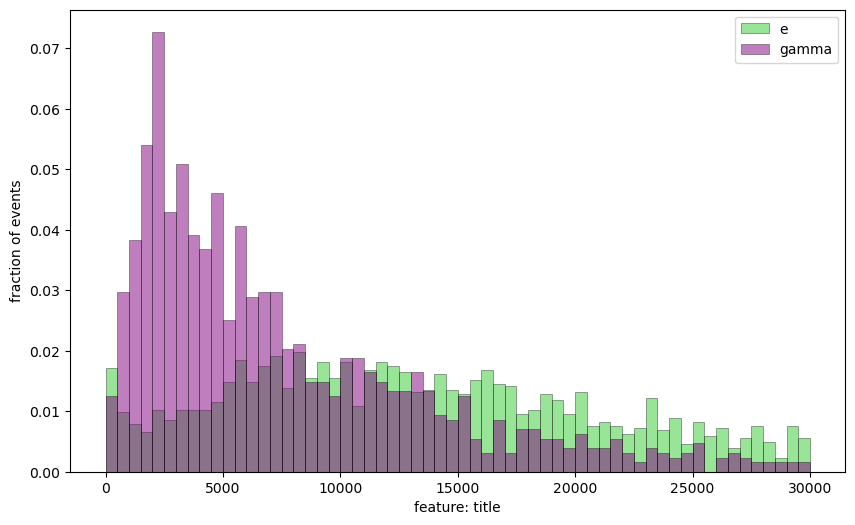

In [7]:
def dEdx_arrays(events, idx_array):
    e = np.array([])
    gamma = np.array([])

    for i in idx_array:
        pdg = events.mc_pdg[i]
        val = dEdx(events, i)

        if pdg == 22:
            gamma = np.append(gamma, val)
        else: e = np.append(e, val)

    return e, gamma

e_arr, gamma_arr = dEdx_arrays(cheated_0, showers_0)

e_arr = [x for x in e_arr if x != None]
gamma_arr = [x for x in gamma_arr if x != None]

pdf = f.feature_histogram_2('title', e_arr, gamma_arr, np.arange(0, 30001, 500))